In [18]:
# Trying out quick concept of MTL:
# Ref: https://towardsdatascience.com/multi-task-learning-with-pytorch-and-fastai-6d10dc7ce855
#     : https://ruder.io/multi-task/

In [19]:
# Multi-Task Learning (MTL) model is a model that is able to do more than one task. It is as simple as that. 
# In general, as soon as you find yourself optimizing more than one loss function, you are effectively doing MTL.

In [20]:
# Dataset: https://www.kaggle.com/jangedoo/utkface-new
# Datatype: Image - Labels: Age,Gender,Ethnicity

In [21]:
# “MTL improves generalization by leveraging the domain-specific information contained in the training signals of related tasks”.

In [22]:
# The focus on running this experiment is not more on finetuning/data augmentation but more of trying gain a practical aspect of multitask learning, trying to optimize multiple losses at a time. 

In [23]:
# importing the "tarfile" module
import tarfile

In [24]:
import zipfile
with zipfile.ZipFile("UTKFace.zip", 'r') as zip_ref:
    zip_ref.extractall('./UTKFaceFolder')

In [25]:
with zipfile.ZipFile("crop_part1.zip", 'r') as zip_ref:
    zip_ref.extractall('./CropPart1')

In [26]:
# open file
"""utkfacefile = tarfile.open('UTKFace.tar.gz')
# extracting file
utkfacefile.extractall('./UTKFaceFolder')
utkfacefile.close()"""

"utkfacefile = tarfile.open('UTKFace.tar.gz')\n# extracting file\nutkfacefile.extractall('./UTKFaceFolder')\nutkfacefile.close()"

In [27]:
"""# open file
crop_part1 = tarfile.open('crop_part1.tar.gz')
# extracting file
crop_part1.extractall('./CropPart1')
crop_part1.close()"""

"# open file\ncrop_part1 = tarfile.open('crop_part1.tar.gz')\n# extracting file\ncrop_part1.extractall('./CropPart1')\ncrop_part1.close()"

In [28]:
from fastai import *
from fastai.vision import *
from fastai.layers import MSELossFlat, CrossEntropyFlat
from torchvision import transforms
import warnings

In [29]:
# Get image files in path recursively, only in folders, if specified.
# This is simply get_files called with a list of standard image extensions.

In [30]:
files_train = get_image_files("UTKFaceFolder/UTKFace")
files_validation = get_image_files("CropPart1/crop_part1")

In [31]:
len(files_train), len(files_validation)

(23708, 9779)

The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

[age] is an integer from 0 to 116, indicating the age
[gender] is either 0 (male) or 1 (female)
[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [32]:
df_train = pd.DataFrame(files_train,columns=["name"])
df_train.name = df_train.name.apply(str)

In [33]:
df_train

,name
0,UTKFaceFolder/UTKFace/46_1_0_20170110151342799...
1,UTKFaceFolder/UTKFace/8_1_0_20170109202314510....
2,UTKFaceFolder/UTKFace/26_0_2_20170116181354956...
3,UTKFaceFolder/UTKFace/24_0_1_20170113151024815...
4,UTKFaceFolder/UTKFace/27_0_1_20170117164420634...
...,...
23703,UTKFaceFolder/UTKFace/35_1_0_20170117185628434...
23704,UTKFaceFolder/UTKFace/28_0_1_20170117020909688...
23705,UTKFaceFolder/UTKFace/30_0_0_20170117181232946...
23706,UTKFaceFolder/UTKFace/28_0_1_20170116192030399...


In [34]:
# Get label
df_train["label"] = df_train.name.apply(lambda x: re.findall(r"\d{1,3}_\d_\d",x)[0])

In [35]:
df_train["label"]

0        46_1_0
1         8_1_0
2        26_0_2
3        24_0_1
4        27_0_1
          ...  
23703    35_1_0
23704    28_0_1
23705    30_0_0
23706    28_0_1
23707     3_1_2
Name: label, Length: 23708, dtype: object

In [36]:
# Replace _ with " "
df_train["label"] = df_train.label.apply(lambda x: re.sub("_"," ", x))
df_train["label"]

0        46 1 0
1         8 1 0
2        26 0 2
3        24 0 1
4        27 0 1
          ...  
23703    35 1 0
23704    28 0 1
23705    30 0 0
23706    28 0 1
23707     3 1 2
Name: label, Length: 23708, dtype: object

In [37]:
df_train["age"] = df_train.label.apply(lambda x: int(x.split(" ")[0]))
df_train["gender"] = df_train.label.apply(lambda x: int(x.split(" ")[1]))
df_train["ethnicity"] = df_train.label.apply(lambda x: int(x.split(" ")[2]))

In [38]:
df_train.head()

,name,label,age,gender,ethnicity
0,UTKFaceFolder/UTKFace/46_1_0_20170110151342799...,46 1 0,46,1,0
1,UTKFaceFolder/UTKFace/8_1_0_20170109202314510....,8 1 0,8,1,0
2,UTKFaceFolder/UTKFace/26_0_2_20170116181354956...,26 0 2,26,0,2
3,UTKFaceFolder/UTKFace/24_0_1_20170113151024815...,24 0 1,24,0,1
4,UTKFaceFolder/UTKFace/27_0_1_20170117164420634...,27 0 1,27,0,1


In [39]:
df_validation = pd.DataFrame(files_validation,columns=["name"])
df_validation.name = df_validation.name.apply(str)
df_validation["label"] = df_validation.name.apply(lambda x: re.findall(r"\d{1,3}_\d_\d",x)[0])
df_validation["label"] = df_validation.label.apply(lambda x: re.sub("_"," ", x))
df_validation["age"] = df_validation.label.apply(lambda x: int(x.split(" ")[0]))
df_validation["gender"] = df_validation.label.apply(lambda x: int(x.split(" ")[1]))
df_validation["ethnicity"] = df_validation.label.apply(lambda x: int(x.split(" ")[2]))

In [40]:
df_validation.head()

,name,label,age,gender,ethnicity
0,CropPart1/crop_part1/46_1_0_20170110151342799....,46 1 0,46,1,0
1,CropPart1/crop_part1/8_1_0_20170109202314510.j...,8 1 0,8,1,0
2,CropPart1/crop_part1/1_0_0_20161219191012803.j...,1 0 0,1,0,0
3,CropPart1/crop_part1/47_0_0_20170104211911013....,47 0 0,47,0,0
4,CropPart1/crop_part1/2_0_3_20161219230614992.j...,2 0 3,2,0,3


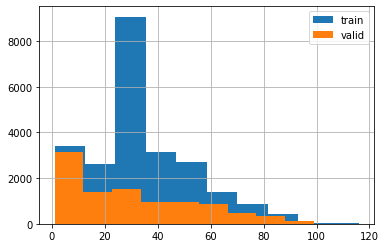

In [41]:
#checking distribution for ages
df_train.age.hist()
df_validation.age.hist()
plt.legend(["train","valid"]);

In [42]:
#should be only 0s and 1s
df_train.gender.unique(), df_validation.gender.unique()

(array([1, 0]), array([1, 0]))

In [43]:
df_train.ethnicity.unique(), df_validation.ethnicity.unique()

(array([0, 2, 1, 3, 4]), array([0, 3, 1, 4, 2]))

In [44]:
#fixing the label
idx = df_validation[df_validation.gender == 3].index
df_validation.loc[idx,"gender"] = 1 #1 means woman

In [45]:
from torchvision import transforms

In [46]:
class MultiTaskDataset(Dataset):
    def __init__(self,df, tfms, size=64):
        self.paths = list(df.name)
        self.labels = list(df.label)
        self.tfms = tfms
        self.size = size
        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats

    def __len__(self): return len(self.paths)

    def __getitem__(self,idx):
        #dealing with the image
        img = PIL.Image.open(self.paths[idx]).convert('RGB')
        img = Image(pil2tensor(img, dtype=np.float32).div_(255))
        img = img.apply_tfms(self.tfms, size = self.size)
        img = self.norm(img.data)

        #dealing with the labels
        labels = self.labels[idx].split(" ")
        age = torch.tensor(float(labels[0]), dtype=torch.float32)
        gender = torch.tensor(int(labels[1]), dtype=torch.int64)
        ethnicity = torch.tensor(int(labels[2]), dtype=torch.int64)
        
        return img.data, (age.log_()/4.75, gender, ethnicity)

    def show(self,idx):
        x,y = self.__getitem__(idx)
        age,gender,ethnicity = y
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        img = ((x.numpy().transpose((1,2,0))*stds + means)*255).astype(np.uint8)
        plt.imshow(img)
        plt.title("{} {} {}".format(int(age.mul_(4.75).exp_().item()), gender.item(), ethnicity.item()))

In [47]:
tfms = get_transforms()
train_ds = MultiTaskDataset(df_train, tfms[0], size=64)
valid_ds = MultiTaskDataset(df_validation, tfms[1], size=64)
train_dl = DataLoader(train_ds, batch_size=512, shuffle=True, num_workers=2)
valid_dl = DataLoader(valid_ds, batch_size=512, shuffle=True, num_workers=2)
data = DataBunch(train_dl, valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


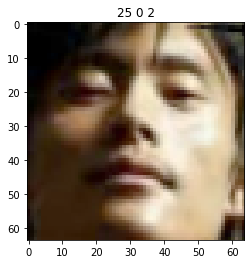

In [48]:
train_ds.show(2)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


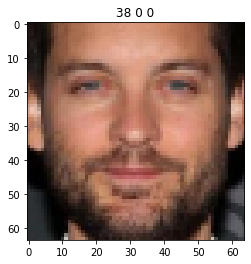

In [49]:
valid_ds.show(9)

In [50]:
# Creating Model:
class MultiTaskModel(nn.Module):
    def __init__(self, arch,ps=0.5):
        super(MultiTaskModel,self).__init__()
        self.encoder = create_body(arch)
        self.fc1 = create_head(1024,1,ps=ps)
        self.fc2 = create_head(1024,2,ps=ps)
        self.fc3 = create_head(1024,5,ps=ps)

    def forward(self,x):

        x = self.encoder(x)
        age = torch.sigmoid(self.fc1(x))
        gender = self.fc2(x)
        ethnicity = self.fc3(x)

        return [age, gender, ethnicity]

In [51]:
# Create Loss
class MultiTaskLossWrapper(nn.Module):
    def __init__(self, task_num):
        super(MultiTaskLossWrapper, self).__init__()
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))

    def forward(self, preds, age, gender, ethnicity):

        mse, crossEntropy = MSELossFlat(), CrossEntropyFlat()
        
        sages = (age*4.75).exp_()
        idx1 = (sages <20) | ((sages > 40) & (sages <= 60))
        idx2 = sages > 60
        loss0 = mse(preds[0], age) + 2*mse(preds[0][idx1],age[idx1]) + 3*mse(preds[0][idx2],age[idx2]) #trying to account for the imbalance
        print("loss0")
        print(loss0)
        loss1 = crossEntropy(preds[1],gender)
        print("loss1")
        print(loss1)
        loss2 = crossEntropy(preds[2],ethnicity)
        print("loss2")
        print(loss2)

        precision0 = torch.exp(-self.log_vars[0])
        loss0 = precision0*loss0 + self.log_vars[0]

        precision1 = torch.exp(-self.log_vars[1])
        loss1 = precision1*loss1 + self.log_vars[1]

        precision2 = torch.exp(-self.log_vars[2])
        loss2 = precision2*loss2 + self.log_vars[2]
        
        return loss0+loss1+loss2

In [52]:
def rmse_age(preds, age, gender, ethnicity): return root_mean_squared_error(preds[0],age)
def acc_gender(preds, age, gender, ethnicity): return accuracy(preds[1], gender)
def acc_ethnicity(preds, age, gender, ethnicity): return accuracy(preds[2], ethnicity)
metrics = [rmse_age, acc_gender, acc_ethnicity]

In [53]:
model = MultiTaskModel(models.resnet34, ps=0.25)

loss_func = MultiTaskLossWrapper(3).to(data.device) #just making sure the loss is on the gpu

learn = Learner(data, model, loss_func=loss_func, callback_fns=ShowGraph, metrics=metrics)

#spliting the model so that I can use discriminative learning rates
learn.split([learn.model.encoder[:6],
             learn.model.encoder[6:],
             nn.ModuleList([learn.model.fc1, learn.model.fc2, learn.model.fc3])]);

#first I'll train only the last layer group (the heads)
learn.freeze()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 


loss0
tensor(0.8936, grad_fn=<AddBackward0>)
loss1
tensor(0.7988, grad_fn=<NllLossBackward0>)
loss2
tensor(1.7860, grad_fn=<NllLossBackward0>)
loss0
tensor(0.8727, grad_fn=<AddBackward0>)
loss1
tensor(0.7603, grad_fn=<NllLossBackward0>)
loss2
tensor(1.7504, grad_fn=<NllLossBackward0>)
loss0
tensor(0.9894, grad_fn=<AddBackward0>)
loss1
tensor(0.8238, grad_fn=<NllLossBackward0>)
loss2
tensor(1.7824, grad_fn=<NllLossBackward0>)
loss0
tensor(0.8496, grad_fn=<AddBackward0>)
loss1
tensor(0.7885, grad_fn=<NllLossBackward0>)
loss2
tensor(1.8117, grad_fn=<NllLossBackward0>)
loss0
tensor(0.8876, grad_fn=<AddBackward0>)
loss1
tensor(0.7894, grad_fn=<NllLossBackward0>)
loss2
tensor(1.8080, grad_fn=<NllLossBackward0>)
loss0
tensor(0.9159, grad_fn=<AddBackward0>)
loss1
tensor(0.7195, grad_fn=<NllLossBackward0>)
loss2
tensor(1.8108, grad_fn=<NllLossBackward0>)
loss0
tensor(0.7968, grad_fn=<AddBackward0>)
loss1
tensor(0.8045, grad_fn=<NllLossBackward0>)
loss2
tensor(1.8021, grad_fn=<NllLossBackward0>)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 


loss0
tensor(0.3033, grad_fn=<AddBackward0>)
loss1
tensor(0.5734, grad_fn=<NllLossBackward0>)
loss2
tensor(1.3985, grad_fn=<NllLossBackward0>)
loss0
tensor(0.3587, grad_fn=<AddBackward0>)
loss1
tensor(0.5793, grad_fn=<NllLossBackward0>)
loss2
tensor(1.3824, grad_fn=<NllLossBackward0>)
loss0
tensor(0.3840, grad_fn=<AddBackward0>)
loss1
tensor(0.6519, grad_fn=<NllLossBackward0>)
loss2
tensor(1.3660, grad_fn=<NllLossBackward0>)
loss0
tensor(0.3610, grad_fn=<AddBackward0>)
loss1
tensor(0.6828, grad_fn=<NllLossBackward0>)
loss2
tensor(1.3292, grad_fn=<NllLossBackward0>)
loss0
tensor(0.3564, grad_fn=<AddBackward0>)
loss1
tensor(0.6222, grad_fn=<NllLossBackward0>)
loss2
tensor(1.3830, grad_fn=<NllLossBackward0>)
loss0
tensor(0.3489, grad_fn=<AddBackward0>)
loss1
tensor(0.6718, grad_fn=<NllLossBackward0>)
loss2
tensor(1.4076, grad_fn=<NllLossBackward0>)
loss0
tensor(0.3843, grad_fn=<AddBackward0>)
loss1
tensor(0.5712, grad_fn=<NllLossBackward0>)
loss2
tensor(1.3545, grad_fn=<NllLossBackward0>)

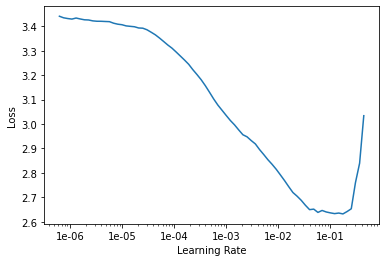

In [54]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,rmse_age,acc_gender,acc_ethnicity,time
0,2.921134,2.373713,0.268861,0.694140,0.447387,15:55
1,2.472892,1.973755,0.237043,0.722467,0.555681,15:57
2,2.230764,1.832078,0.222408,0.738726,0.588915,15:50
3,2.087118,1.744768,0.205771,0.747622,0.604970,15:52
4,1.978931,1.675935,0.193163,0.749668,0.623990,15:56
5,1.900453,1.640144,0.192787,0.750793,0.634830,16:01
6,1.834824,1.599597,0.186498,0.756008,0.639534,16:02
7,1.797749,1.581937,0.179420,0.759689,0.638818,16:01
8,1.772240,1.580734,0.179609,0.758667,0.638000,16:03
9,1.764238,1.570621,0.179266,0.758462,0.642397,16:03


/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced

loss0
tensor(0.9004, grad_fn=<AddBackward0>)
loss1
tensor(0.7863, grad_fn=<NllLossBackward0>)
loss2
tensor(1.7899, grad_fn=<NllLossBackward0>)
loss0
tensor(0.8773, grad_fn=<AddBackward0>)
loss1
tensor(0.7810, grad_fn=<NllLossBackward0>)
loss2
tensor(1.8108, grad_fn=<NllLossBackward0>)
loss0
tensor(0.7588, grad_fn=<AddBackward0>)
loss1
tensor(0.7902, grad_fn=<NllLossBackward0>)
loss2
tensor(1.8103, grad_fn=<NllLossBackward0>)
loss0
tensor(0.8825, grad_fn=<AddBackward0>)
loss1
tensor(0.7793, grad_fn=<NllLossBackward0>)
loss2
tensor(1.7875, grad_fn=<NllLossBackward0>)
loss0
tensor(0.8146, grad_fn=<AddBackward0>)
loss1
tensor(0.7232, grad_fn=<NllLossBackward0>)
loss2
tensor(1.8186, grad_fn=<NllLossBackward0>)
loss0
tensor(0.7974, grad_fn=<AddBackward0>)
loss1
tensor(0.7671, grad_fn=<NllLossBackward0>)
loss2
tensor(1.8039, grad_fn=<NllLossBackward0>)
loss0
tensor(0.7220, grad_fn=<AddBackward0>)
loss1
tensor(0.7594, grad_fn=<NllLossBackward0>)
loss2
tensor(1.7604, grad_fn=<NllLossBackward0>)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

loss0
tensor(0.3979)
loss1
tensor(0.5865)
loss2
tensor(1.3973)
loss0
tensor(0.4189)
loss1
tensor(0.5662)
loss2
tensor(1.4512)
loss0
tensor(0.4038)
loss1
tensor(0.5732)
loss2
tensor(1.3746)
loss0
tensor(0.3309)
loss1
tensor(0.5653)
loss2
tensor(1.4067)
loss0
tensor(0.3811)
loss1
tensor(0.5788)
loss2
tensor(1.3873)
loss0
tensor(0.4131)
loss1
tensor(0.5370)
loss2
tensor(1.3851)
loss0
tensor(0.3852)
loss1
tensor(0.5662)
loss2
tensor(1.3987)
loss0
tensor(0.3288)
loss1
tensor(0.6202)
loss2
tensor(1.3488)
loss0
tensor(0.3921)
loss1
tensor(0.5574)
loss2
tensor(1.3759)
loss0
tensor(0.4308)
loss1
tensor(0.5905)
loss2
tensor(1.4163)
loss0
tensor(0.3170)
loss1
tensor(0.6209)
loss2
tensor(1.4130)
loss0
tensor(0.3823)
loss1
tensor(0.5831)
loss2
tensor(1.3513)
loss0
tensor(0.4159)
loss1
tensor(0.5930)
loss2
tensor(1.4060)
loss0
tensor(0.3928)
loss1
tensor(0.6078)
loss2
tensor(1.4299)
loss0
tensor(0.3840)
loss1
tensor(0.5699)
loss2
tensor(1.3893)
loss0
tensor(0.4555)
loss1
tensor(0.5628)
loss2
tensor(

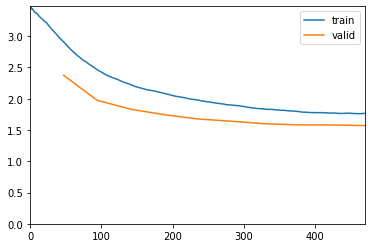

Better model found at epoch 0 with valid_loss value: 2.3737125396728516.


/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced

loss0
tensor(0.4455, grad_fn=<AddBackward0>)
loss1
tensor(0.6210, grad_fn=<NllLossBackward0>)
loss2
tensor(1.5085, grad_fn=<NllLossBackward0>)
loss0
tensor(0.3574, grad_fn=<AddBackward0>)
loss1
tensor(0.6506, grad_fn=<NllLossBackward0>)
loss2
tensor(1.5376, grad_fn=<NllLossBackward0>)
loss0
tensor(0.3637, grad_fn=<AddBackward0>)
loss1
tensor(0.6215, grad_fn=<NllLossBackward0>)
loss2
tensor(1.5294, grad_fn=<NllLossBackward0>)
loss0
tensor(0.4061, grad_fn=<AddBackward0>)
loss1
tensor(0.6191, grad_fn=<NllLossBackward0>)
loss2
tensor(1.4527, grad_fn=<NllLossBackward0>)
loss0
tensor(0.4395, grad_fn=<AddBackward0>)
loss1
tensor(0.6075, grad_fn=<NllLossBackward0>)
loss2
tensor(1.3848, grad_fn=<NllLossBackward0>)
loss0
tensor(0.3896, grad_fn=<AddBackward0>)
loss1
tensor(0.5395, grad_fn=<NllLossBackward0>)
loss2
tensor(1.4500, grad_fn=<NllLossBackward0>)
loss0
tensor(0.4316, grad_fn=<AddBackward0>)
loss1
tensor(0.5666, grad_fn=<NllLossBackward0>)
loss2
tensor(1.4356, grad_fn=<NllLossBackward0>)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

loss0
tensor(0.2593)
loss1
tensor(0.5297)
loss2
tensor(1.1842)
loss0
tensor(0.2464)
loss1
tensor(0.5209)
loss2
tensor(1.1477)
loss0
tensor(0.2476)
loss1
tensor(0.5075)
loss2
tensor(1.1410)
loss0
tensor(0.2731)
loss1
tensor(0.5402)
loss2
tensor(1.2067)
loss0
tensor(0.2343)
loss1
tensor(0.5031)
loss2
tensor(1.1987)
loss0
tensor(0.2489)
loss1
tensor(0.5197)
loss2
tensor(1.1410)
loss0
tensor(0.2646)
loss1
tensor(0.5681)
loss2
tensor(1.1430)
loss0
tensor(0.3016)
loss1
tensor(0.5452)
loss2
tensor(1.1318)
loss0
tensor(0.2636)
loss1
tensor(0.5659)
loss2
tensor(1.2480)
loss0
tensor(0.3215)
loss1
tensor(0.5430)
loss2
tensor(1.2448)
loss0
tensor(0.2614)
loss1
tensor(0.5357)
loss2
tensor(1.1756)
loss0
tensor(0.2792)
loss1
tensor(0.4957)
loss2
tensor(1.1790)
loss0
tensor(0.2766)
loss1
tensor(0.5355)
loss2
tensor(1.1764)
loss0
tensor(0.2278)
loss1
tensor(0.5201)
loss2
tensor(1.1695)
loss0
tensor(0.2334)
loss1
tensor(0.5353)
loss2
tensor(1.1889)
loss0
tensor(0.2789)
loss1
tensor(0.5163)
loss2
tensor(

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../a

loss0
tensor(0.2836, grad_fn=<AddBackward0>)
loss1
tensor(0.5763, grad_fn=<NllLossBackward0>)
loss2
tensor(1.2933, grad_fn=<NllLossBackward0>)
loss0
tensor(0.3250, grad_fn=<AddBackward0>)
loss1
tensor(0.5045, grad_fn=<NllLossBackward0>)
loss2
tensor(1.2884, grad_fn=<NllLossBackward0>)
loss0
tensor(0.3773, grad_fn=<AddBackward0>)
loss1
tensor(0.5679, grad_fn=<NllLossBackward0>)
loss2
tensor(1.2416, grad_fn=<NllLossBackward0>)
loss0
tensor(0.2943, grad_fn=<AddBackward0>)
loss1
tensor(0.5631, grad_fn=<NllLossBackward0>)
loss2
tensor(1.2891, grad_fn=<NllLossBackward0>)
loss0
tensor(0.2742, grad_fn=<AddBackward0>)
loss1
tensor(0.5920, grad_fn=<NllLossBackward0>)
loss2
tensor(1.3643, grad_fn=<NllLossBackward0>)
loss0
tensor(0.3295, grad_fn=<AddBackward0>)
loss1
tensor(0.5169, grad_fn=<NllLossBackward0>)
loss2
tensor(1.2926, grad_fn=<NllLossBackward0>)
loss0
tensor(0.3184, grad_fn=<AddBackward0>)
loss1
tensor(0.5421, grad_fn=<NllLossBackward0>)
loss2
tensor(1.2880, grad_fn=<NllLossBackward0>)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

loss0
tensor(0.2006)
loss1
tensor(0.5320)
loss2
tensor(1.1071)
loss0
tensor(0.2057)
loss1
tensor(0.5462)
loss2
tensor(1.0658)
loss0
tensor(0.1991)
loss1
tensor(0.5273)
loss2
tensor(1.0886)
loss0
tensor(0.2421)
loss1
tensor(0.5049)
loss2
tensor(1.1002)
loss0
tensor(0.2621)
loss1
tensor(0.4863)
loss2
tensor(1.1004)
loss0
tensor(0.1883)
loss1
tensor(0.5393)
loss2
tensor(1.0822)
loss0
tensor(0.2218)
loss1
tensor(0.5077)
loss2
tensor(1.1065)
loss0
tensor(0.2733)
loss1
tensor(0.4936)
loss2
tensor(1.0987)
loss0
tensor(0.2439)
loss1
tensor(0.5095)
loss2
tensor(1.0567)
loss0
tensor(0.1995)
loss1
tensor(0.4594)
loss2
tensor(1.1484)
loss0
tensor(0.1875)
loss1
tensor(0.4792)
loss2
tensor(1.1195)
loss0
tensor(0.2225)
loss1
tensor(0.5088)
loss2
tensor(1.0171)
loss0
tensor(0.2116)
loss1
tensor(0.4876)
loss2
tensor(1.1075)
loss0
tensor(0.2431)
loss1
tensor(0.5805)
loss2
tensor(1.1804)
loss0
tensor(0.2510)
loss1
tensor(0.5133)
loss2
tensor(1.0885)
loss0
tensor(0.1820)
loss1
tensor(0.5182)
loss2
tensor(

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 


loss0
tensor(0.2532, grad_fn=<AddBackward0>)
loss1
tensor(0.5042, grad_fn=<NllLossBackward0>)
loss2
tensor(1.2269, grad_fn=<NllLossBackward0>)
loss0
tensor(0.2302, grad_fn=<AddBackward0>)
loss1
tensor(0.5454, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1600, grad_fn=<NllLossBackward0>)
loss0
tensor(0.2918, grad_fn=<AddBackward0>)
loss1
tensor(0.5926, grad_fn=<NllLossBackward0>)
loss2
tensor(1.2608, grad_fn=<NllLossBackward0>)
loss0
tensor(0.2211, grad_fn=<AddBackward0>)
loss1
tensor(0.5236, grad_fn=<NllLossBackward0>)
loss2
tensor(1.2175, grad_fn=<NllLossBackward0>)
loss0
tensor(0.2489, grad_fn=<AddBackward0>)
loss1
tensor(0.5055, grad_fn=<NllLossBackward0>)
loss2
tensor(1.2165, grad_fn=<NllLossBackward0>)
loss0
tensor(0.2850, grad_fn=<AddBackward0>)
loss1
tensor(0.5261, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1261, grad_fn=<NllLossBackward0>)
loss0
tensor(0.2324, grad_fn=<AddBackward0>)
loss1
tensor(0.5223, grad_fn=<NllLossBackward0>)
loss2
tensor(1.2212, grad_fn=<NllLossBackward0>)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

loss0
tensor(0.2027)
loss1
tensor(0.5443)
loss2
tensor(1.0832)
loss0
tensor(0.1783)
loss1
tensor(0.5194)
loss2
tensor(1.0728)
loss0
tensor(0.2047)
loss1
tensor(0.5160)
loss2
tensor(1.0794)
loss0
tensor(0.2654)
loss1
tensor(0.4619)
loss2
tensor(1.0387)
loss0
tensor(0.1482)
loss1
tensor(0.5175)
loss2
tensor(1.0660)
loss0
tensor(0.2110)
loss1
tensor(0.5345)
loss2
tensor(1.0949)
loss0
tensor(0.1792)
loss1
tensor(0.4797)
loss2
tensor(1.0297)
loss0
tensor(0.1957)
loss1
tensor(0.4704)
loss2
tensor(1.0151)
loss0
tensor(0.1880)
loss1
tensor(0.4733)
loss2
tensor(0.9968)
loss0
tensor(0.1872)
loss1
tensor(0.4884)
loss2
tensor(1.0740)
loss0
tensor(0.1944)
loss1
tensor(0.5041)
loss2
tensor(1.0035)
loss0
tensor(0.1645)
loss1
tensor(0.5211)
loss2
tensor(1.0704)
loss0
tensor(0.1925)
loss1
tensor(0.4865)
loss2
tensor(1.0253)
loss0
tensor(0.1983)
loss1
tensor(0.4788)
loss2
tensor(1.0753)
loss0
tensor(0.1874)
loss1
tensor(0.4993)
loss2
tensor(0.9854)
loss0
tensor(0.1740)
loss1
tensor(0.4865)
loss2
tensor(

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 


loss0
tensor(0.2983, grad_fn=<AddBackward0>)
loss1
tensor(0.5529, grad_fn=<NllLossBackward0>)
loss2
tensor(1.2099, grad_fn=<NllLossBackward0>)
loss0
tensor(0.2096, grad_fn=<AddBackward0>)
loss1
tensor(0.5213, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1336, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1957, grad_fn=<AddBackward0>)
loss1
tensor(0.5932, grad_fn=<NllLossBackward0>)
loss2
tensor(1.2202, grad_fn=<NllLossBackward0>)
loss0
tensor(0.2240, grad_fn=<AddBackward0>)
loss1
tensor(0.5095, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1649, grad_fn=<NllLossBackward0>)
loss0
tensor(0.2512, grad_fn=<AddBackward0>)
loss1
tensor(0.5201, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1606, grad_fn=<NllLossBackward0>)
loss0
tensor(0.2285, grad_fn=<AddBackward0>)
loss1
tensor(0.4953, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1384, grad_fn=<NllLossBackward0>)
loss0
tensor(0.2130, grad_fn=<AddBackward0>)
loss1
tensor(0.5048, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1869, grad_fn=<NllLossBackward0>)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

loss0
tensor(0.2101)
loss1
tensor(0.5112)
loss2
tensor(0.9946)
loss0
tensor(0.1712)
loss1
tensor(0.5142)
loss2
tensor(1.0587)
loss0
tensor(0.1690)
loss1
tensor(0.4980)
loss2
tensor(0.9737)
loss0
tensor(0.1702)
loss1
tensor(0.4681)
loss2
tensor(1.0343)
loss0
tensor(0.1805)
loss1
tensor(0.4879)
loss2
tensor(1.0259)
loss0
tensor(0.1469)
loss1
tensor(0.5102)
loss2
tensor(0.9700)
loss0
tensor(0.1563)
loss1
tensor(0.5308)
loss2
tensor(1.0162)
loss0
tensor(0.1595)
loss1
tensor(0.5436)
loss2
tensor(1.0626)
loss0
tensor(0.1398)
loss1
tensor(0.4568)
loss2
tensor(1.0193)
loss0
tensor(0.1736)
loss1
tensor(0.4784)
loss2
tensor(1.0489)
loss0
tensor(0.1718)
loss1
tensor(0.4814)
loss2
tensor(0.9584)
loss0
tensor(0.1910)
loss1
tensor(0.4734)
loss2
tensor(0.9634)
loss0
tensor(0.1363)
loss1
tensor(0.5223)
loss2
tensor(1.0465)
loss0
tensor(0.1791)
loss1
tensor(0.4859)
loss2
tensor(0.9924)
loss0
tensor(0.1769)
loss1
tensor(0.4805)
loss2
tensor(1.0695)
loss0
tensor(0.1625)
loss1
tensor(0.4989)
loss2
tensor(

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../a

loss0
tensor(0.2279, grad_fn=<AddBackward0>)
loss1
tensor(0.5269, grad_fn=<NllLossBackward0>)
loss2
tensor(1.2244, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1938, grad_fn=<AddBackward0>)
loss1
tensor(0.5052, grad_fn=<NllLossBackward0>)
loss2
tensor(1.2238, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1983, grad_fn=<AddBackward0>)
loss1
tensor(0.4872, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1442, grad_fn=<NllLossBackward0>)
loss0
tensor(0.2133, grad_fn=<AddBackward0>)
loss1
tensor(0.5095, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1167, grad_fn=<NllLossBackward0>)
loss0
tensor(0.2030, grad_fn=<AddBackward0>)
loss1
tensor(0.5075, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1254, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1495, grad_fn=<AddBackward0>)
loss1
tensor(0.5307, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1679, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1781, grad_fn=<AddBackward0>)
loss1
tensor(0.5545, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1525, grad_fn=<NllLossBackward0>)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

loss0
tensor(0.1635)
loss1
tensor(0.4841)
loss2
tensor(0.9877)
loss0
tensor(0.1806)
loss1
tensor(0.4911)
loss2
tensor(0.9428)
loss0
tensor(0.1750)
loss1
tensor(0.5246)
loss2
tensor(1.0305)
loss0
tensor(0.1678)
loss1
tensor(0.5122)
loss2
tensor(0.9916)
loss0
tensor(0.1494)
loss1
tensor(0.4944)
loss2
tensor(1.0225)
loss0
tensor(0.1691)
loss1
tensor(0.5119)
loss2
tensor(0.9651)
loss0
tensor(0.1836)
loss1
tensor(0.4507)
loss2
tensor(0.9529)
loss0
tensor(0.1842)
loss1
tensor(0.5087)
loss2
tensor(0.9983)
loss0
tensor(0.1795)
loss1
tensor(0.4909)
loss2
tensor(0.9791)
loss0
tensor(0.1562)
loss1
tensor(0.5058)
loss2
tensor(0.9657)
loss0
tensor(0.1772)
loss1
tensor(0.4927)
loss2
tensor(1.0349)
loss0
tensor(0.1574)
loss1
tensor(0.5238)
loss2
tensor(0.9703)
loss0
tensor(0.1869)
loss1
tensor(0.4961)
loss2
tensor(0.9528)
loss0
tensor(0.1355)
loss1
tensor(0.4833)
loss2
tensor(0.9273)
loss0
tensor(0.1599)
loss1
tensor(0.4410)
loss2
tensor(0.9759)
loss0
tensor(0.1767)
loss1
tensor(0.4577)
loss2
tensor(

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 


loss0
tensor(0.2320, grad_fn=<AddBackward0>)
loss1
tensor(0.4893, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1398, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1638, grad_fn=<AddBackward0>)
loss1
tensor(0.4813, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1483, grad_fn=<NllLossBackward0>)
loss0
tensor(0.2029, grad_fn=<AddBackward0>)
loss1
tensor(0.4831, grad_fn=<NllLossBackward0>)
loss2
tensor(1.2123, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1811, grad_fn=<AddBackward0>)
loss1
tensor(0.4793, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1411, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1812, grad_fn=<AddBackward0>)
loss1
tensor(0.4747, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1695, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1861, grad_fn=<AddBackward0>)
loss1
tensor(0.5054, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1049, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1421, grad_fn=<AddBackward0>)
loss1
tensor(0.4655, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1839, grad_fn=<NllLossBackward0>)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

loss0
tensor(0.1615)
loss1
tensor(0.4902)
loss2
tensor(0.9984)
loss0
tensor(0.1328)
loss1
tensor(0.4976)
loss2
tensor(0.9683)
loss0
tensor(0.1615)
loss1
tensor(0.4643)
loss2
tensor(0.9700)
loss0
tensor(0.1606)
loss1
tensor(0.5075)
loss2
tensor(0.9593)
loss0
tensor(0.1354)
loss1
tensor(0.4354)
loss2
tensor(0.9607)
loss0
tensor(0.1336)
loss1
tensor(0.4574)
loss2
tensor(0.9926)
loss0
tensor(0.1435)
loss1
tensor(0.4853)
loss2
tensor(0.9501)
loss0
tensor(0.1508)
loss1
tensor(0.4714)
loss2
tensor(0.9715)
loss0
tensor(0.1440)
loss1
tensor(0.4803)
loss2
tensor(0.9665)
loss0
tensor(0.1612)
loss1
tensor(0.5079)
loss2
tensor(0.9669)
loss0
tensor(0.1603)
loss1
tensor(0.4596)
loss2
tensor(0.9749)
loss0
tensor(0.1455)
loss1
tensor(0.4783)
loss2
tensor(0.9141)
loss0
tensor(0.1615)
loss1
tensor(0.4650)
loss2
tensor(0.9088)
loss0
tensor(0.1669)
loss1
tensor(0.4580)
loss2
tensor(0.9695)
loss0
tensor(0.1387)
loss1
tensor(0.4989)
loss2
tensor(0.9162)
loss0
tensor(0.1845)
loss1
tensor(0.4969)
loss2
tensor(

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../a

loss0
tensor(0.2084, grad_fn=<AddBackward0>)
loss1
tensor(0.4928, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1387, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1283, grad_fn=<AddBackward0>)
loss1
tensor(0.4936, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1264, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1727, grad_fn=<AddBackward0>)
loss1
tensor(0.4852, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1101, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1683, grad_fn=<AddBackward0>)
loss1
tensor(0.5162, grad_fn=<NllLossBackward0>)
loss2
tensor(1.0820, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1507, grad_fn=<AddBackward0>)
loss1
tensor(0.5106, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1179, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1797, grad_fn=<AddBackward0>)
loss1
tensor(0.4595, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1954, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1929, grad_fn=<AddBackward0>)
loss1
tensor(0.4965, grad_fn=<NllLossBackward0>)
loss2
tensor(1.0946, grad_fn=<NllLossBackward0>)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

loss0
tensor(0.1908)
loss1
tensor(0.5091)
loss2
tensor(1.0013)
loss0
tensor(0.1534)
loss1
tensor(0.4793)
loss2
tensor(1.0002)
loss0
tensor(0.1489)
loss1
tensor(0.4658)
loss2
tensor(0.9849)
loss0
tensor(0.1209)
loss1
tensor(0.4887)
loss2
tensor(0.9416)
loss0
tensor(0.1384)
loss1
tensor(0.4520)
loss2
tensor(0.9144)
loss0
tensor(0.1482)
loss1
tensor(0.5159)
loss2
tensor(0.9243)
loss0
tensor(0.1629)
loss1
tensor(0.4713)
loss2
tensor(0.9848)
loss0
tensor(0.1199)
loss1
tensor(0.4523)
loss2
tensor(0.9868)
loss0
tensor(0.1356)
loss1
tensor(0.4684)
loss2
tensor(0.9057)
loss0
tensor(0.1296)
loss1
tensor(0.4752)
loss2
tensor(0.9561)
loss0
tensor(0.1373)
loss1
tensor(0.4704)
loss2
tensor(0.9302)
loss0
tensor(0.1811)
loss1
tensor(0.4610)
loss2
tensor(0.9368)
loss0
tensor(0.1554)
loss1
tensor(0.4490)
loss2
tensor(0.8859)
loss0
tensor(0.1240)
loss1
tensor(0.5013)
loss2
tensor(0.9138)
loss0
tensor(0.1400)
loss1
tensor(0.4424)
loss2
tensor(0.9791)
loss0
tensor(0.1641)
loss1
tensor(0.4822)
loss2
tensor(

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 


loss0
tensor(0.1568, grad_fn=<AddBackward0>)
loss1
tensor(0.4833, grad_fn=<NllLossBackward0>)
loss2
tensor(1.0588, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1641, grad_fn=<AddBackward0>)
loss1
tensor(0.4612, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1421, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1499, grad_fn=<AddBackward0>)
loss1
tensor(0.5187, grad_fn=<NllLossBackward0>)
loss2
tensor(1.0646, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1435, grad_fn=<AddBackward0>)
loss1
tensor(0.4933, grad_fn=<NllLossBackward0>)
loss2
tensor(1.0136, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1477, grad_fn=<AddBackward0>)
loss1
tensor(0.4895, grad_fn=<NllLossBackward0>)
loss2
tensor(1.0444, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1310, grad_fn=<AddBackward0>)
loss1
tensor(0.4689, grad_fn=<NllLossBackward0>)
loss2
tensor(1.0482, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1526, grad_fn=<AddBackward0>)
loss1
tensor(0.4889, grad_fn=<NllLossBackward0>)
loss2
tensor(1.0971, grad_fn=<NllLossBackward0>)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

loss0
tensor(0.1482)
loss1
tensor(0.4964)
loss2
tensor(1.0169)
loss0
tensor(0.1273)
loss1
tensor(0.4876)
loss2
tensor(0.9928)
loss0
tensor(0.1251)
loss1
tensor(0.4607)
loss2
tensor(0.9744)
loss0
tensor(0.1416)
loss1
tensor(0.4831)
loss2
tensor(1.0013)
loss0
tensor(0.1664)
loss1
tensor(0.4887)
loss2
tensor(0.9697)
loss0
tensor(0.1687)
loss1
tensor(0.4526)
loss2
tensor(0.9768)
loss0
tensor(0.1379)
loss1
tensor(0.4612)
loss2
tensor(0.9722)
loss0
tensor(0.1692)
loss1
tensor(0.4454)
loss2
tensor(0.9164)
loss0
tensor(0.1352)
loss1
tensor(0.4622)
loss2
tensor(0.9799)
loss0
tensor(0.1644)
loss1
tensor(0.5036)
loss2
tensor(0.9722)
loss0
tensor(0.1259)
loss1
tensor(0.4682)
loss2
tensor(0.9569)
loss0
tensor(0.1250)
loss1
tensor(0.4834)
loss2
tensor(0.9707)
loss0
tensor(0.1406)
loss1
tensor(0.4929)
loss2
tensor(1.0002)
loss0
tensor(0.1679)
loss1
tensor(0.4781)
loss2
tensor(0.8987)
loss0
tensor(0.1401)
loss1
tensor(0.4877)
loss2
tensor(0.8688)
loss0
tensor(0.1350)
loss1
tensor(0.4443)
loss2
tensor(

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 


loss0
tensor(0.1360, grad_fn=<AddBackward0>)
loss1
tensor(0.5111, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1213, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1471, grad_fn=<AddBackward0>)
loss1
tensor(0.4715, grad_fn=<NllLossBackward0>)
loss2
tensor(1.0724, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1533, grad_fn=<AddBackward0>)
loss1
tensor(0.4731, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1264, grad_fn=<NllLossBackward0>)
loss0
tensor(0.2185, grad_fn=<AddBackward0>)
loss1
tensor(0.4902, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1423, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1404, grad_fn=<AddBackward0>)
loss1
tensor(0.5121, grad_fn=<NllLossBackward0>)
loss2
tensor(1.0162, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1249, grad_fn=<AddBackward0>)
loss1
tensor(0.5011, grad_fn=<NllLossBackward0>)
loss2
tensor(1.1299, grad_fn=<NllLossBackward0>)
loss0
tensor(0.1194, grad_fn=<AddBackward0>)
loss1
tensor(0.5230, grad_fn=<NllLossBackward0>)
loss2
tensor(1.0537, grad_fn=<NllLossBackward0>)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

loss0
tensor(0.1460)
loss1
tensor(0.4746)
loss2
tensor(0.8680)
loss0
tensor(0.1597)
loss1
tensor(0.5025)
loss2
tensor(0.9947)
loss0
tensor(0.1496)
loss1
tensor(0.4866)
loss2
tensor(0.9274)
loss0
tensor(0.1400)
loss1
tensor(0.4521)
loss2
tensor(0.9559)
loss0
tensor(0.1583)
loss1
tensor(0.4951)
loss2
tensor(0.9496)
loss0
tensor(0.1369)
loss1
tensor(0.4866)
loss2
tensor(0.9192)
loss0
tensor(0.1487)
loss1
tensor(0.4583)
loss2
tensor(0.9547)
loss0
tensor(0.1400)
loss1
tensor(0.4563)
loss2
tensor(0.9667)
loss0
tensor(0.1361)
loss1
tensor(0.4988)
loss2
tensor(1.0076)
loss0
tensor(0.1436)
loss1
tensor(0.4834)
loss2
tensor(0.9285)
loss0
tensor(0.1834)
loss1
tensor(0.4414)
loss2
tensor(1.0308)
loss0
tensor(0.1260)
loss1
tensor(0.5136)
loss2
tensor(0.9457)
loss0
tensor(0.1038)
loss1
tensor(0.4802)
loss2
tensor(0.9601)
loss0
tensor(0.1348)
loss1
tensor(0.4703)
loss2
tensor(0.9135)
loss0
tensor(0.1468)
loss1
tensor(0.4582)
loss2
tensor(0.9823)
loss0
tensor(0.1584)
loss1
tensor(0.4682)
loss2
tensor(

In [55]:
learn.fit_one_cycle(10,max_lr=slice(1e-6,3e-4),
                   callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='trial')])

In [56]:
trained_model = learn.model.cpu()
torch.save(trained_model.state_dict(),"model_params_resnet34")

In [57]:
class Inference():
    def __init__(self, model):
        self.model = model
        self.tfms = get_transforms()[1]
        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats
        self.gender = {0:"Male",1:"Female"}
        self.ethnicity = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}

    def predict(self,x):
        #x is a PIL Image
        x = Image(pil2tensor(x, dtype=np.float32).div_(255))
        x = x.apply_tfms(self.tfms, size = 64)
        x = self.norm(x.data)
        preds = self.model(x.unsqueeze(0))
        age = int(torch.exp(preds[0]*4.75).item())
        gender = self.gender[torch.softmax(preds[1],1).argmax().item()]
        ethnicity = self.ethnicity[torch.softmax(preds[2],1).argmax().item()]
        return age, gender, ethnicity

In [58]:
Inference = Inference(trained_model)

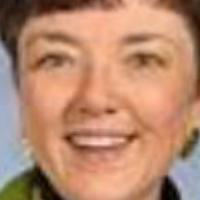

In [61]:
img = PIL.Image.open(df_validation.name.iloc[130])
img

In [62]:
Inference.predict(img)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


(48, 'Female', 'White')